# Introduction à l'apprentissage par renforcement
# TP 1 - le bandit-manchot multi-bras

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

# Définition des vaccins

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class ArmBernoulli:
    def __init__(self, p: float, random_state: int = 0):
        """
        Bernoulli arm
        Args:
             p (float): mean parameter
             random_state (int): seed to make experiments reproducible
        """
        self.mean = p
        self.local_random = np.random.RandomState(random_state)
        
    def sample(self, printable = False):
        random = self.local_random.rand()
        
        if printable:
            print (f"random: {random}, mean: {self.mean}")
        return random < self.mean

    
K = 5
T = 100
np.random.seed(1)
means = np.random.random(K)
MAB = [ArmBernoulli(m) for m in means]
assert(MAB[0].mean == means[0])

In [4]:
means

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01])

In [5]:
list(map(lambda arm: arm.mean, MAB))

[0.417022004702574,
 0.7203244934421581,
 0.00011437481734488664,
 0.30233257263183977,
 0.14675589081711304]

In [6]:
MAB[0].sample(printable=True)

random: 0.5488135039273248, mean: 0.417022004702574


False

**Vaccins :** ils sont notés $A_k\leq K$, leur probabilité d'immunisation est $p_k = \mu_k$.

**Récompense :** 1 si le patient $t$ est immunisé et 0 sinon.

**Action optimale :** choisir le vaccin $a$ avec la meilleure probabilité $a^* = \arg\max_{a\leq K} \mu_{a}$.

**Regret :** $R_T =T\mu_a^* - \mathbb{E} \left[ \sum_{t=1}^T r_t \right]$
En notant $N_a(t)$, le nombre de fois que le vaccin $a$ a été choisi jusqu'à $t$ et $\Delta_a = \mu_a^* - \mu_a$, le regret s'exprime :

$$R_T = \sum_{a=1}^K \Delta_a \mathbb{E} \left[ N_{a_T} \right]$$


**Expliquez ce que signifie le regret concrètement. Pourquoi minimiser le regret donne une bonne solution au problème du bandit-manchot** <br><br>
Le regret signifie l'accumulation de la différence entre la récompense maximale et la récompense obtenue.<br>
Plus on avance en exploration avec une stratégie qui n'est pas la stratégie optimale plus le regret augmente.<br>
Ainsi minimiser le regret permet de maximiser la récompense obtenue car il permet de s'orienter vers la stratégie optimale.

# Solution naive

 La solution naive consiste en 2 étapes distinctes :

1. Entraînement : on teste les K vaccins sur N patients et on note leur efficacité séparemment
2. Exploitation : le vaccin qui apparaît comme le meilleur est choisi pour les T-N patients restants.

**Implémentez cet algorithme avec T=100, N=20, K=5. Quel bras a été choisi lors de la seconde phase ?**

In [7]:
N = 20
nb_groupe = K # here 5 
groupe_size = int(N / nb_groupe) # here 4
rewards = np.zeros((nb_groupe, groupe_size)) 


In [30]:
def compute_rewards(rewards, nb_groupe, groupe_size):
    rewards = np.zeros((nb_groupe, groupe_size))
    for groupe in range(nb_groupe):
        rewards[groupe] = [MAB[groupe].sample() for i in range(groupe_size)]
    return rewards

rewards = compute_rewards(rewards, nb_groupe, groupe_size)
rewards

array([[0., 1., 1., 1.],
       [0., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 1., 1., 0.]])

In [31]:
list_vaccin = rewards.flatten()
list_vaccin

array([0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 0.])

On estime quel vaccin produit la meilleure immunisation sur les n premiers patients :

$R_𝑖 = (1/T_𝑖) \sum_{k=0}^{n−1} X_(v_k,i) R_𝑘$

On choisit le vaccin avec le meilleur (𝑅_𝑖 ) pour tous les patients suivants.


In [32]:
r_i = rewards.mean(axis=1)
print(f"{r_i = }")

best_groupe = np.argmax(r_i)
print(f"{best_groupe = }")

r_i = array([0.75, 0.25, 0.5 , 0.25, 0.75])
best_groupe = 0


In [11]:
def choose_bestgroupe():
    r = compute_rewards(rewards, nb_groupe)
    r_i = r.mean(axis=1)
    best_groupe = np.argmax(r_i)

    return best_groupe, r.flatten()

**Obtenez-vous toujours le même résultat ? Testez l'algorithme avec une valeur de N plus faible. Qu'en concluez-vous ?** <br><br>
Le résultat obtenu est aléatoire car on ne teste pas tous les vaccins sur tous les patients. <br>
Plus N est faible plus le résultat est incertain du à la loi des grands nombres. <br>
On peut conclure que le choix du vaccin après la phase d'entreinement n'est peut être pas le meilleur dépendemmment de la valeur de N. <br>

**Tracez l'évolution du regret $r_t$ de votre algorithme en fonction du résultat obtenu avec le patient $t<T$ sur plusieurs expériences. Représentez l'évolution moyenne de ce regret sur plusieurs expériences.**

In [12]:
def Regret_i(N, mu, list_vaccine):
    """
        N : number of patients tested
        mu : mean reward of the best vaccin
        list_vaccine : list of rewards for each patient
    """
    E = np.sum(list_vaccine) 
    return N * mu - E

In [13]:
mu_opti = np.max(means)
mu_opti

0.7203244934421581

In [14]:
list(map(lambda arm: arm.mean, MAB))

[0.417022004702574,
 0.7203244934421581,
 0.00011437481734488664,
 0.30233257263183977,
 0.14675589081711304]

In [15]:
def compute_regret(l, vaccin, MAB):
    list_vaccin = list(l.copy())
    mu_opti = np.max(list(map(lambda arm: arm.mean, MAB)))
    r = []

    ## Entrainement
    for i in range(1, N):
        r.append(Regret_i(i, mu_opti, list_vaccin[:i]))

    ## Exploration
    for i in range(T-N):
        list_vaccin.append(MAB[vaccin].sample())
        r.append(Regret_i(len(list_vaccin), mu_opti, list_vaccin[:N+i+1]))
    return r


In [16]:
list_regret = []
best = []

for j  in range(100):
    regrets = []
    best_groupe, list_vaccin = choose_bestgroupe()
    best.append(best_groupe)
    for i in range(K):
        regrets.append(compute_regret(list_vaccin, i, MAB))
    list_regret.append(regrets)
list_regret = np.array(list_regret)
regrets = list_regret.mean(axis=0)
regrets.shape 

(5, 99)

In [17]:
b = np.unique(best, return_counts=True)
choose = np.argmax(b[1])
best_groupe = b[0][choose]
best_groupe

1

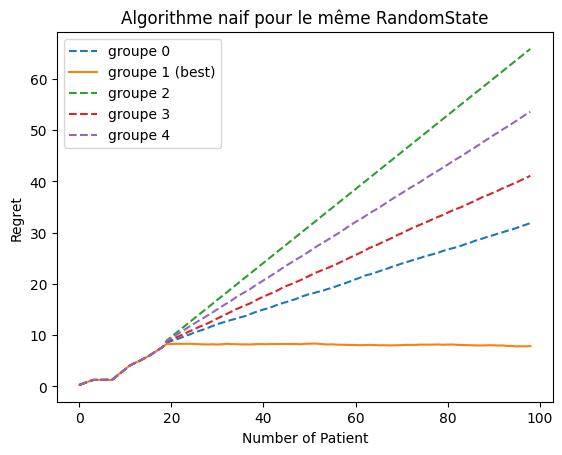

In [18]:
for i in range(K):    
    if i == best_groupe:
        plt.plot(regrets[i], label=f"groupe {i} (best)")
    else:
        plt.plot(regrets[i],  '--', label=f"groupe {i}",)
plt.xlabel("Number of Patient")
plt.ylabel("Regret")  
plt.title("Algorithme naif pour le même RandomState")  
plt.legend()

Text(0.5, 1.0, 'Algorithme naif (RandomState différent à chaque fois)')

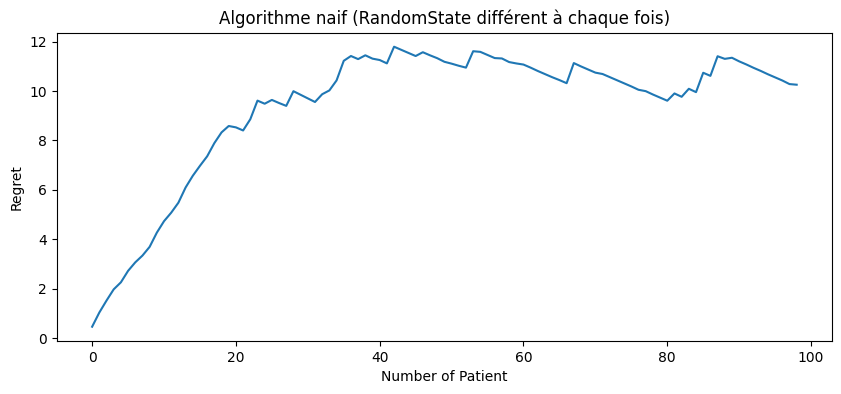

In [19]:

regrets = []
for i  in range(100):
    means = np.random.random(K)
    MAB = [ArmBernoulli(m) for m in means]
    best_groupe, list_vaccin = choose_bestgroupe()
    regrets.append(compute_regret(list_vaccin, best_groupe, MAB))
    
regrets = np.mean(regrets, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(regrets)
plt.xlabel("Number of Patient")
plt.ylabel("Regret")  
plt.title("Algorithme naif (RandomState différent à chaque fois)")


## Upper Confidence Bounds (P. Auer, 2002)

L'action $a_t$ l'instant $t$ est donnée par : 

$$a_t = max_a \left[ X_t(a) + B_t(a) \right]$$

où $X_t(a)$ est la moyenne empirique de la récompense obtenue avec le vaccin $a$ et $B_t(a)$ est un biais :

$B_t(a) = \sqrt{ \frac{2\log t}{T_a}}$ où $T_a$ est le nombre de fois que le vaccin $a$ a été choisi.

**Pourquoi cet algorithme n'a pas besoin d'une phase d'entraînement ? Quel terme favorise l'exploration et quel terme favorise l'exploitation ?** <bR><br>
Upper Confidence Bounds n'a pas besoin d'une phase d'entrainement car il estime la récompense de chaque vaccin à chaque instant t. <br>
Le terme $X_t(a)$ favorise l'exploitation car il estime la récompense moyenne du vaccin choisi. <br>
Le terme $B_t(a)$ favorise l'exploration, il mesure l'incertitude sur la récompense moyenne de chaque vaccin.<br>
Plus $T_a$ est grand plus $B_t(a)$ est petit et plus on exploite le vaccin a avec certitude. <br>

**Implémentez l'algorithme et tracez l'évolution du regret à partir de cet algorithme.**

In [36]:

def upper_bound(T, mu_opti, K, MAB, k=1):
    list_patient =[[] for _ in range(K)]
    list_a = [10 for _ in range(K)]
    list_regret = []
    list_choice = []
    
    for i in range(1, T):
        a = np.argmax(list_a)
        
        list_patient[a].append(MAB[a].sample())
        
        N = i
        T_i = len(list_patient[a])
        X_i = np.mean(list_patient[a])
        biais = np.sqrt(2 * np.log(N) / T_i)
        list_a[a] = X_i + k * biais
        
        list_regret.append(Regret_i(N, mu_opti, [x for sublist in list_patient for x in sublist]))
        list_choice.append(a)

    return list_regret, list_choice


On regarde ce que donne l'algorithme UCB sur les 100 patients pour 1 expérience et on analyse le comportment de l'algorithme.

In [47]:
means_ucb = np.random.random(K)
MAB_ucb = [ArmBernoulli(m) for m in means_ucb]
mu_opti_ucb = np.max(means_ucb)
list_regret, list_choice = upper_bound(T, mu_opti_ucb, K, MAB_ucb)

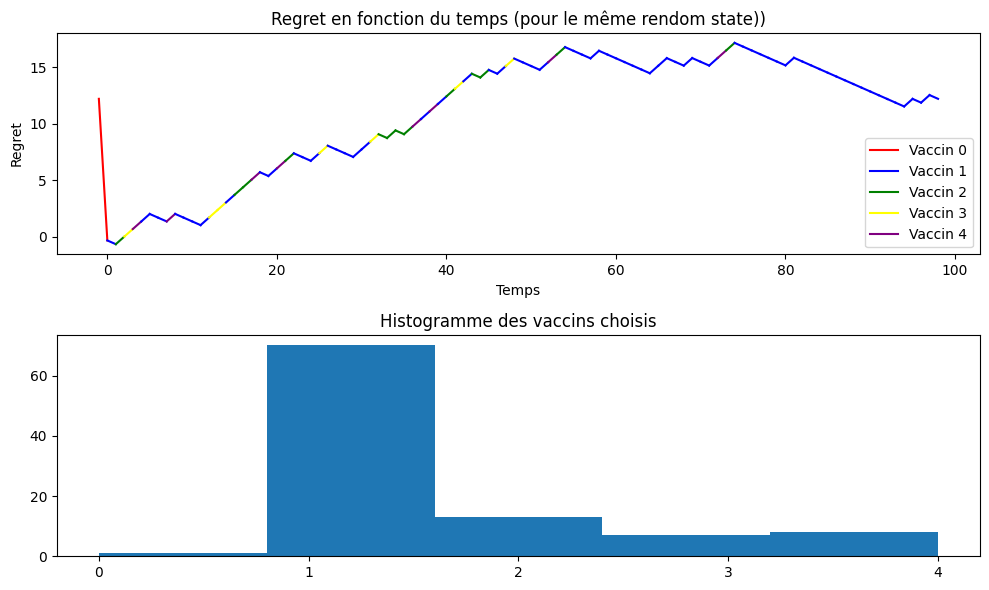

In [48]:
colors = ['red', 'blue', 'green', 'yellow', 'purple']
labeled = []

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
for t in range(0, len(list_regret)):
    if (list_choice[t] not in labeled):
        plt.plot([t-1, t], [list_regret[t-1], list_regret[t]], color=colors[list_choice[t]], label=f'Vaccin {list_choice[t]}')
        labeled.append(list_choice[t])
    else:
        plt.plot([t-1, t], [list_regret[t-1], list_regret[t]], color=colors[list_choice[t]])
plt.title("Regret en fonction du temps (pour le même rendom state))")
plt.xlabel("Temps")
plt.ylabel("Regret")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Histogramme des vaccins choisis")
plt.hist(list_choice, bins=K)
plt.xticks(range(K))

plt.tight_layout()

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des valeurs de $(X_a)_a$ et de $(B_a)_a$ au cours du temps**

On repete plusieurs fois l'expérience pour voir l'évolution du regret moyen.

In [63]:
mean_regret_ucb = []

for i in range(100):
    means_ucb2 = np.random.random(K)
    MAB_ucb2 = [ArmBernoulli(m) for m in means_ucb2]
    mu_opti_ucb2 = np.max(means_ucb2)
    list_regret, _ = upper_bound(T, mu_opti_ucb2, K, MAB_ucb2)
    mean_regret_ucb.append(list_regret)
means_regret_ucb = np.mean(mean_regret_ucb, axis=0)
len(mean_regret_ucb)

100

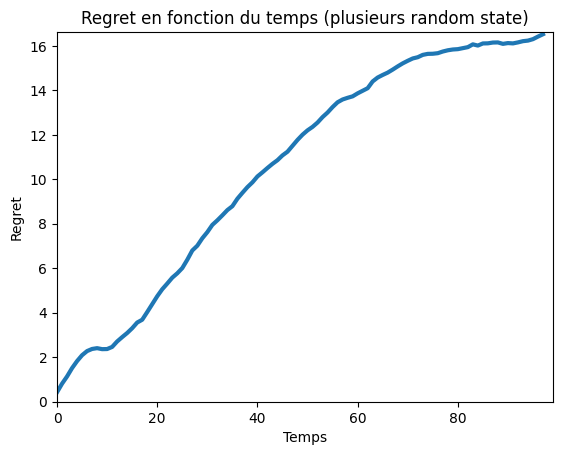

In [76]:
import matplotlib.animation
from IPython.display import HTML
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    ax.set_xlim(0, len(means_regret_ucb))
    ax.set_ylim(0, max(means_regret_ucb))
    ax.set_title("Regret en fonction du temps (plusieurs random state)")
    ax.set_xlabel("Temps")
    ax.set_ylabel("Regret")
    return line,

def update(t):
    line.set_data(range(t), np.array(means_regret_ucb)[:t])
    return line,

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(means_regret_ucb/2), init_func=init, blit=True)
HTML(ani.to_jshtml())


# Echantillonnage de Thomson

L'algorithme de Thompson calcule à chaque instant $t$ le paramètre des lois Beta pour tous les vaccins. Il échantillonne alors une probabilité de choisir chaque vaccin et choisit le vaccin avec la plus grande probabilité.

**Comment fonctionnent les lois Beta ? Comment les mettre à jour selon les résultats des vaccins ?** <br><br>
Les lois Beta sont des lois de probabilité qui permettent de modéliser la probabilité de succès des evements et est caractérisé par deux paramètres a, b initialisé à 1. Si c'est un succes on ajoute 1 à la valeur de a sinon on ajoute 1 à la valeur de b. <br>


**Comment se passent l'exploration et l'exploitation ?**<br><br>
Les lois Beta permettent de modéliser la probabilité de succès des vaccins. <br>
On va donc à chaque instant t lancer un random suivant les lois Beta de chaque vaccin et choisir le vaccin qui a la valeur la plus haute valeur<br>

**Implémentez l'algorithme et tracez l'évolution du regret.**

In [110]:
def sample_thomson(T, K, mu_opti, MAB):
    list_patient =[[] for _ in range(K)]
    list_beta = [[1, 1] for _ in range(K)]
    list_regret = []

    evolutions_beta  = [list_beta]

    for i in range(T):
        choice = np.argmax([np.random.beta(list_beta[k][0], list_beta[k][1]) for k in range(K)])
        result = MAB[choice].sample()

        if result:
            list_beta[choice][0] += 1
        else:
            list_beta[choice][1] += 1
        new_list_beta = list_beta.copy()
        evolutions_beta.append(new_list_beta)
        

        list_patient[choice].append(result)
        list_regret.append(Regret_i(i, mu_opti, [x for sublist in list_patient for x in sublist]))

    return list_regret, np.array(evolutions_beta)


In [111]:

means_thomson = np.random.random(K)
MAB_thomson = [ArmBernoulli(m) for m in means_thomson]
mu_opti_thomson = np.max(means_thomson)
list_regret, evolution_beta = sample_thomson(T, K, mu_opti_thomson, MAB_thomson)


In [113]:
evolution_beta.shape

(101, 5, 2)

**Créez une animation avec matplotlib qui permette de visualiser l'évolution des probabilités au cours du temps**

Indice : pour représenter des probabilités, on pourra utiliser des diagrammes en violons.

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots(figsize=(8, 6))

# def update(num):
#     ax.clear()
#     sns.violinplot(y=, ax=ax)
#     ax.set_title(f"Step {num}")

# ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(data), repeat=False)
# HTML(ani.to_jshtml())

